# Bollinger Bands Strategy and Backtesting Report

******************************************************
**Prepared By : Samalie Piwan**  
**Andrew ID: spiwan**  
**Semester: Fall 2023**  
**Last modified: 2nd October 2023**  
******************************************************

## Strategy Backtesting Implementation

In [16]:
#Load the libraries to be used in the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def backtest_strategy(symbol, data_file, date_col, pricing_col, window):
    
    """
    This function backtests a symbol using the bollinger bands strategy to evaluate the strategy's performance
    
    Attributes
    -----------
        symbol : str
            The name of the symbol to be displayed in the graph title
        data_file: str
            The file to load the pricing data from
        date_col: str
            The name of the column to be used as the date in the file loaded
        pricing_col : str
            The name of the column that contains the pricing data
        window:
            The number of days to use when computing the Simple Moving Average
            
    Return
    -----------
        None
    
    """

    #Load the data from the downloaded file
    parent_df = pd.read_csv(data_file).dropna()
    
    main_df = parent_df[[date_col,pricing_col]].copy()

    #Convert the date column to datetime
    main_df[date_col] = pd.to_datetime(main_df[date_col])
    #Set the Date column as the index
    main_df_indexed = main_df.set_index(date_col)

    #Get the SMA value
    sma = main_df_indexed[pricing_col].rolling(window).mean()

    #Calculate the SMA for the simple_moving_average on the dataframe
    main_df_indexed['SMA'] = sma

    #Get the standard deviation of the pricing column
    standard_deviation =  main_df_indexed[pricing_col].rolling(window).std()

    main_df_indexed['Upper Band'] =  sma + standard_deviation * 2
    main_df_indexed['Lower Band'] = sma - standard_deviation * 2

    # Generate the trading signals
    buy_price = []
    sell_price = []
    bands_signal = []
    signal = 0

    for i in range(len(main_df_indexed[pricing_col])):
        if(main_df_indexed[pricing_col][i-1] > main_df_indexed['Lower Band'][i-1] and main_df_indexed[pricing_col][i] < main_df_indexed['Lower Band'][i]):
            if(signal != 1):
                buy_price.append(main_df_indexed[pricing_col][i])
                sell_price.append(np.nan)
                signal = 1
                bands_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bands_signal.append(0)
        elif(main_df_indexed[pricing_col][i-1] < main_df_indexed['Upper Band'][i-1] and main_df_indexed[pricing_col][i] > main_df_indexed['Upper Band'][i]):
            if(signal != -1):
                buy_price.append(np.nan)
                sell_price.append(main_df_indexed[pricing_col][i])
                signal = -1
                bands_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bands_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bands_signal.append(0)

    #Create positions for our strategy
    position = []
    for i in range(len(bands_signal)):
        if bands_signal[i] > 1:
            position.append(0)
        else:
            position.append(1)

    for i in range(len(main_df_indexed[pricing_col])):
        if bands_signal[i] == 1:
            position[i] = 1
        elif bands_signal[i] == -1:
            position[i] = 0
        else:
            position[i] = position[i-1]
            
    #Plot the figures with the trading signals
    plt.figure(figsize = (12,6))
    plt.title(symbol+" Closing Price | SMA "+str(window))
    main_df_indexed[pricing_col].plot(label = 'PRICES', color = 'skyblue')
    main_df_indexed['Upper Band'].plot(label = 'UPPER BAND '+str(window), linestyle = '--', linewidth = 1, color = 'black')
    main_df_indexed['SMA'].plot(label = 'MIDDLE BAND '+str(window), linestyle = '--', linewidth = 1.2, color = 'grey')
    main_df_indexed['Lower Band'].plot(label = 'LOWER BAND '+str(window), linestyle = '--', linewidth = 1, color = 'black')
    plt.scatter(main_df_indexed.index, sell_price, marker = 'v', color = 'red', label = 'SELL', s = 200)
    plt.scatter(main_df_indexed.index, buy_price, marker='^', color = 'green', label = 'BUY', s = 200)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend(loc='upper left')
    plt.show()

    #Create a copy of the main dataset
    main_df_new = main_df_indexed.copy()

    #Add the bands_signal list to the main dataset
    main_df_new['Band Signals'] = bands_signal

    #Add the positions list to the main dataset
    main_df_new['Band Position'] = position

    #Calculate the returns on the data
    main_df_new['Returns'] = np.log(main_df_new[pricing_col] / main_df_new[pricing_col].shift(1))

    #Calculate the performance on the strategy data
    main_df_new['Strategy'] = main_df_new['Band Position'].shift(1) * main_df_new['Returns']
    
    #Compute the cummulative returns from the returns dataset
    main_df_new['Cummulative Strategy'] = main_df_new['Strategy'].cumsum().apply(np.exp)
    main_df_new['Cummulative Returns'] = main_df_new['Returns'].cumsum().apply(np.exp)

    #Plot the figures with the trading signals
    plt.figure(figsize = (12,6))
    plt.title(symbol+" Equity Lines | SMA "+str(window))
    plt.plot(main_df_new['Cummulative Strategy'], label = "Strategy")
    plt.plot(main_df_new['Cummulative Returns'], label = "Returns")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend(loc='upper left')
    plt.show()

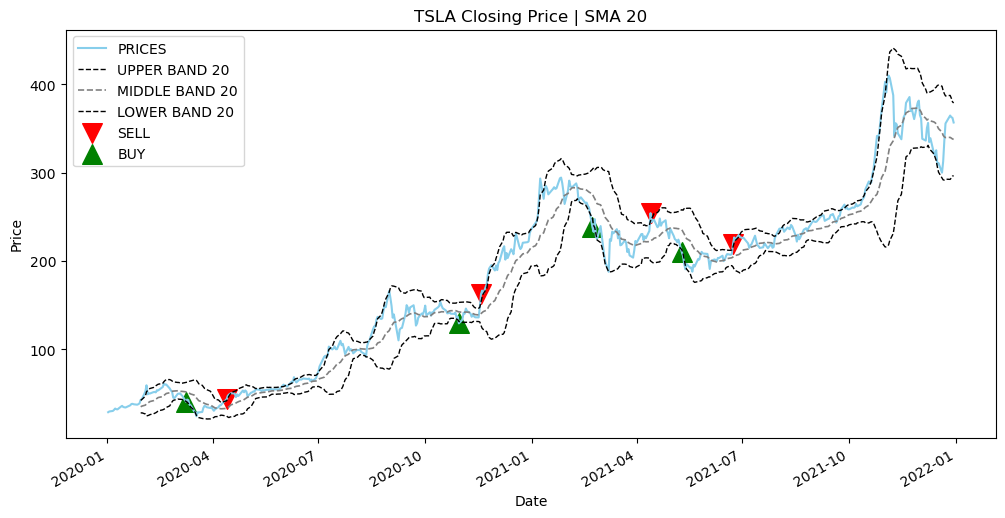

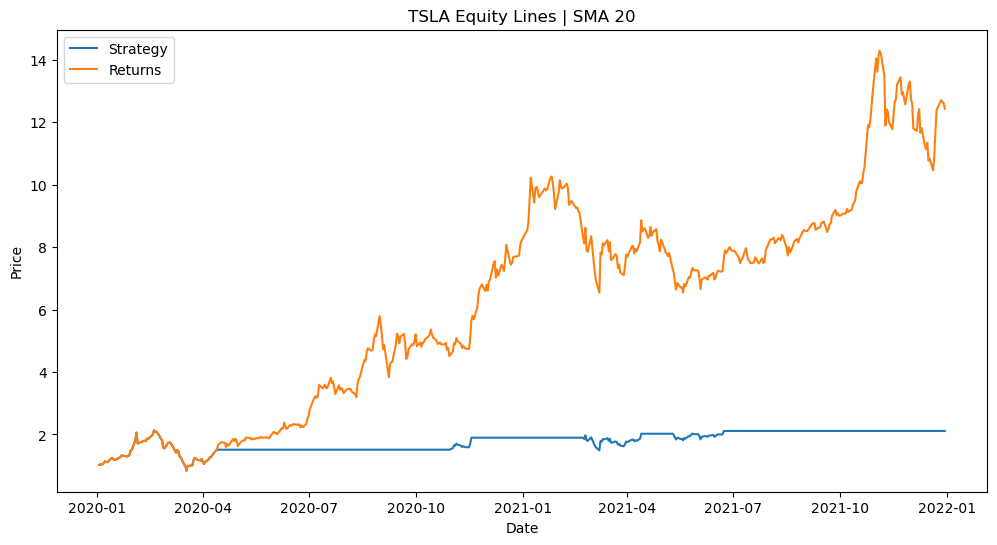

In [17]:
backtest_strategy('TSLA', 'tsla.csv', 'Date', 'Adj Close', 20)

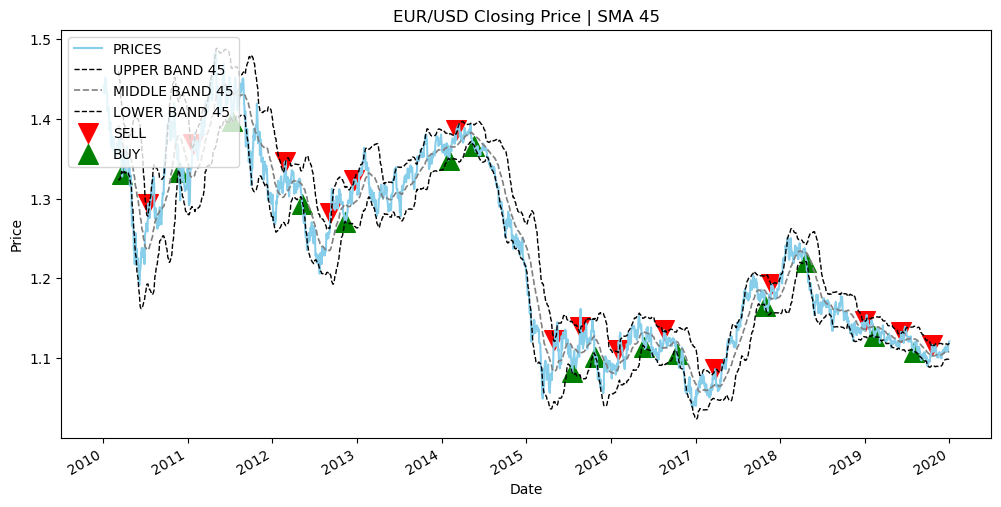

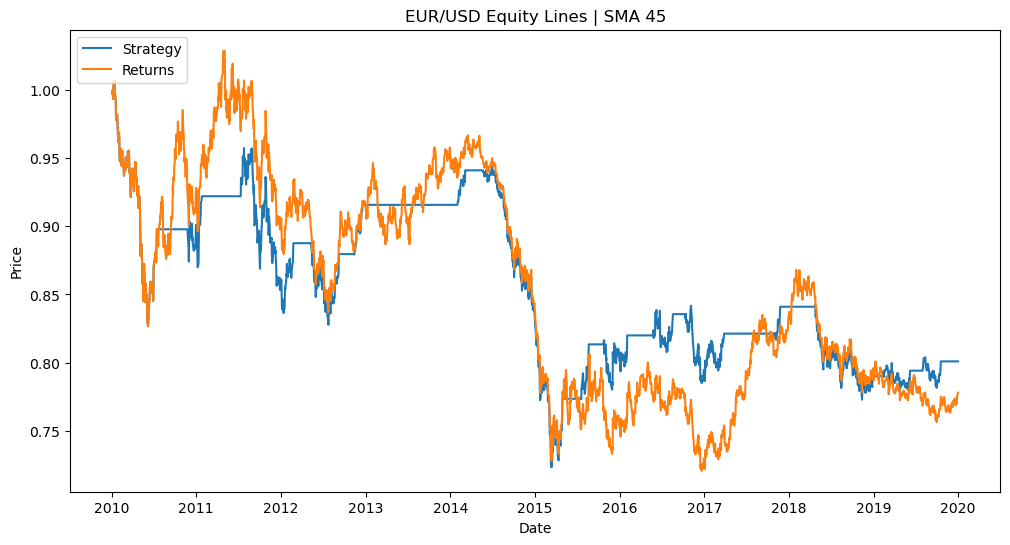

In [18]:
backtest_strategy('EUR/USD', 'pyalgo_eikon_eod_data.csv', 'Date', 'EUR=', 45)

In [35]:
#Load the libraries to be used in the project
import pandas_ta as ta

def backtest_strategy_auto(symbol, data_file, date_col, pricing_col, window):
    
    """
    This function backtests a symbol using the bollinger bands strategy to evaluate the strategy's performance
    
    Attributes
    -----------
        symbol : str
            The name of the symbol to be displayed in the graph title
        data_file: str
            The file to load the pricing data from
        date_col: str
            The name of the column to be used as the date in the file loaded
        pricing_col : str
            The name of the column that contains the pricing data
        window:
            The number of days to use when computing the Simple Moving Average
            
    Return
    -----------
        None
    
    """

    #Load the data from the downloaded file
    parent_df = pd.read_csv(data_file).dropna()
    
    main_df = parent_df[[date_col,pricing_col]].copy()

    #Convert the date column to datetime
    main_df[date_col] = pd.to_datetime(main_df[date_col])
    #Set the Date column as the index
    main_df_indexed = main_df.set_index(date_col)

    #Get the SMA value
    sma = main_df_indexed[pricing_col].rolling(window).mean()

    #Calculate the SMA for the simple_moving_average on the dataframe
    main_df_indexed['SMA'] = sma

    #Get the standard deviation of the pricing column
    standard_deviation =  main_df_indexed[pricing_col].rolling(window).std()

    main_df_indexed['Upper Band'] =  sma + standard_deviation * 2
    main_df_indexed['Lower Band'] = sma - standard_deviation * 2

    # Generate the trading signals
    buy_price = []
    sell_price = []
    bands_signal = []
    signal = 0

    for i in range(len(main_df_indexed[pricing_col])):
        if(main_df_indexed[pricing_col][i-1] > main_df_indexed['Lower Band'][i-1] and main_df_indexed[pricing_col][i] < main_df_indexed['Lower Band'][i]):
            if(signal != 1):
                buy_price.append(main_df_indexed[pricing_col][i])
                sell_price.append(np.nan)
                signal = 1
                bands_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bands_signal.append(0)
        elif(main_df_indexed[pricing_col][i-1] < main_df_indexed['Upper Band'][i-1] and main_df_indexed[pricing_col][i] > main_df_indexed['Upper Band'][i]):
            if(signal != -1):
                buy_price.append(np.nan)
                sell_price.append(main_df_indexed[pricing_col][i])
                signal = -1
                bands_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bands_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bands_signal.append(0)

    #Create positions for our strategy
    position = []
    for i in range(len(bands_signal)):
        if bands_signal[i] > 1:
            position.append(0)
        else:
            position.append(1)

    for i in range(len(main_df_indexed[pricing_col])):
        if bands_signal[i] == 1:
            position[i] = 1
        elif bands_signal[i] == -1:
            position[i] = 0
        else:
            position[i] = position[i-1]
            
    #Plot the figures with the trading signals
    """plt.figure(figsize = (12,6))
    plt.title(symbol+" Closing Price | SMA "+str(window))
    main_df_indexed[pricing_col].plot(label = 'PRICES', color = 'skyblue')
    main_df_indexed['Upper Band'].plot(label = 'UPPER BAND '+str(window), linestyle = '--', linewidth = 1, color = 'black')
    main_df_indexed['SMA'].plot(label = 'MIDDLE BAND '+str(window), linestyle = '--', linewidth = 1.2, color = 'grey')
    main_df_indexed['Lower Band'].plot(label = 'LOWER BAND '+str(window), linestyle = '--', linewidth = 1, color = 'black')
    plt.scatter(main_df_indexed.index, sell_price, marker = 'v', color = 'red', label = 'SELL', s = 200)
    plt.scatter(main_df_indexed.index, buy_price, marker='^', color = 'green', label = 'BUY', s = 200)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend(loc='upper left')
    plt.show()"""

    #Create a copy of the main dataset
    main_df_new = main_df_indexed.copy()

    #Add the bands_signal list to the main dataset
    main_df_new['Band Signals'] = bands_signal

    #Add the positions list to the main dataset
    main_df_new['Band Position'] = position

    #Calculate the returns on the data
    #main_df_new['Returns'] = np.log(main_df_new[pricing_col] / main_df_new[pricing_col].shift(1))

    #Calculate the performance on the strategy data
    #main_df_new['Strategy'] = main_df_new['Band Position'].shift(1) * main_df_new['Returns']
    
    #Compute the cummulative returns from the returns dataset
    #main_df_new['Cummulative Strategy'] = main_df_new['Strategy'].cumsum().apply(np.exp)
    #main_df_new['Cummulative Returns'] = main_df_new['Returns'].cumsum().apply(np.exp)
    
    # Calculate Returns and append to the df DataFrame
    main_df_new['Cummulative Returns'] = main_df_new.ta.log_return(close="EUR=",cumulative=True, append=True)
    main_df_new['Cummulative Pct Returns'] = main_df_new.ta.percent_return(close="EUR=",cumulative=True, append=True)

    #Plot the figures with the trading signals
    plt.figure(figsize = (12,6))
    plt.title(symbol+" Equity Lines | SMA "+str(window))
    plt.plot(main_df_new['Cummulative Returns'], label = "Returns")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend(loc='upper left')
    plt.show()

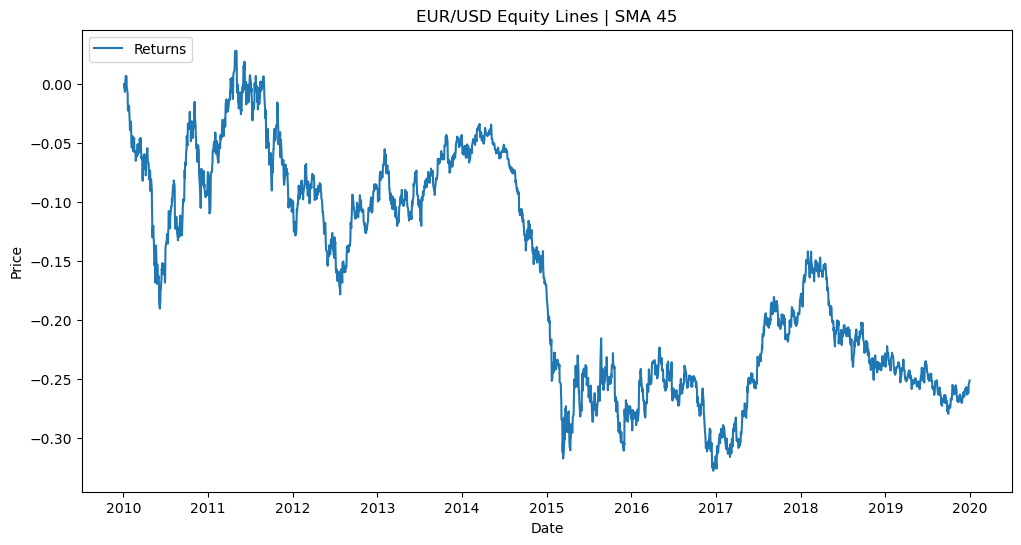

In [36]:
backtest_strategy_auto('EUR/USD', 'pyalgo_eikon_eod_data.csv', 'Date', 'EUR=', 45)

In [62]:
#Load the data from the downloaded file
parent_df = pd.read_csv('pyalgo_eikon_eod_data.csv').dropna()

main_df = parent_df[['Date','EUR=']].copy()

#Convert the date column to datetime
main_df['Date'] = pd.to_datetime(main_df['Date'])
#Set the Date column as the index
main_df_indexed = main_df.set_index('Date')

#length (int): The short period. Default: 5
#std (int): The long period. Default: 2
#Function returns lower, mid, upper, bandwidth, and percent columns
main_df_indexed.ta.bbands(close='EUR=', length= 10, std= 5, append = True)

main_df_indexed.head()

,EUR=,BBL_10_5.0,BBM_10_5.0,BBU_10_5.0,BBB_10_5.0,BBP_10_5.0
Date,,,,,,
2010-01-04,1.4411,NaN,NaN,NaN,NaN,NaN
2010-01-05,1.4368,NaN,NaN,NaN,NaN,NaN
2010-01-06,1.4412,NaN,NaN,NaN,NaN,NaN
2010-01-07,1.4318,NaN,NaN,NaN,NaN,NaN
2010-01-08,1.4412,NaN,NaN,NaN,NaN,NaN


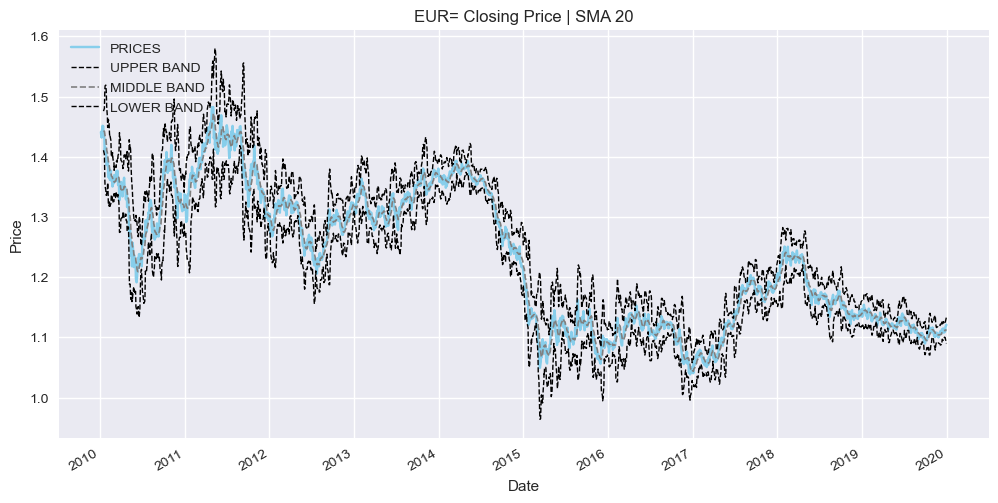

In [63]:
plt.figure(figsize = (12,6))
plt.title("EUR= Closing Price | SMA 20")
main_df_indexed['EUR='].plot(label = 'PRICES', color = 'skyblue')
main_df_indexed['BBU_10_5.0'].plot(label = 'UPPER BAND', linestyle = '--', linewidth = 1, color = 'black')
main_df_indexed['BBM_10_5.0'].plot(label = 'MIDDLE BAND ', linestyle = '--', linewidth = 1.2, color = 'grey')
main_df_indexed['BBL_10_5.0'].plot(label = 'LOWER BAND ', linestyle = '--', linewidth = 1, color = 'black')
#plt.scatter(main_df_indexed.index, sell_price, marker = 'v', color = 'red', label = 'SELL', s = 200)
#plt.scatter(main_df_indexed.index, buy_price, marker='^', color = 'green', label = 'BUY', s = 200)
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc='upper left')
plt.show()

In [66]:
# Calculate Returns and append to the df DataFrame
main_df_indexed.ta.log_return(close="EUR=", append=True)
main_df_indexed.ta.log_return(close="EUR=",cumulative=True, append=True)
main_df_indexed.head()

,EUR=,BBL_10_5.0,BBM_10_5.0,BBU_10_5.0,BBB_10_5.0,BBP_10_5.0,LOGRET_1,CUMLOGRET_1
Date,,,,,,,,
2010-01-04,1.4411,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2010-01-05,1.4368,NaN,NaN,NaN,NaN,NaN,-0.002988,-0.002988
2010-01-06,1.4412,NaN,NaN,NaN,NaN,NaN,0.003058,0.000069
2010-01-07,1.4318,NaN,NaN,NaN,NaN,NaN,-0.006544,-0.006474
2010-01-08,1.4412,NaN,NaN,NaN,NaN,NaN,0.006544,0.000069


In [68]:
main_df_indexed["LOGRET_1"].describe()

count    2515.000000
mean       -0.000100
std         0.005636
min        -0.026531
25%        -0.003311
50%         0.000072
75%         0.003049
max         0.030352
Name: LOGRET_1, dtype: float64